In [1]:
%load_ext autoreload
%autoreload 2

import parenclitic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, SVG
import igraph

In [2]:
from configurations.load_data_twins_E_MTAB_7309 import load_data_twins_E_MTAB_7309
from configurations.config_twins_E_MTAB_7309 import config

X, y, mask, all_features_names, age = load_data_twins_E_MTAB_7309()

D:\PC\UNN\Science\Gerontology\data\E-MTAB-7309\genes_norm(quantile)_source(betas).npz
['data']
Data loaded:  0.3506102
float32 (14743, 1059)
(1059, 14743) 14743


In [3]:
from configurations.load_data_age_GSE87571 import load_data_age_GSE87571
from configurations.config_age_GSE87571 import config

X, y, mask, all_features_names, age = load_data_age_GSE87571()

Data loaded:  0.22145279999999978
float32 (729, 14768)
(729, 14768) 14768


In [70]:
sum(y > 0)

554

In [33]:
from configurations.load_data_down_GSE52588 import load_data_down_GSE52588_cpgs
from configurations.config_down_GSE52588_cpg import config

X, y, mask, all_cpg_names = load_data_down_GSE52588_cpgs()

Data loaded:  37.04651380000087
float32 (422801, 87)
(87, 422801)
(87, 422801) 150254 (87,) (422801,)


In [45]:
from configurations.config_age_GSE87571 import config
data = np.load(config.ifname('x'))
X = data['data']
X.shape

(485512, 729)

In [4]:
pair_filter = parenclitic.IG_filter()
pair_filter.fit(X, mask, 0)
print(len(pair_filter))
print(pair_filter.num_good)

85366711
13067


# Mean by genes

In [46]:
from annotations.cpgs import cpgs_annotation
cpgs = cpgs_annotation(config.ifname('cpgs_annotations'))

In [47]:
bad_cpgs = np.loadtxt(config.ifname('bad_cpgs'), dtype='str')

In [51]:
def mean_cpgs_by_genes(X, betas_dict, gene_to_cpgs):
    X_g = np.zeros((len(gene_to_cpgs), X.shape[1]), dtype = np.float32)
    gene_names = list(gene_to_cpgs.keys())
    k = 0
    for gene, cpg_names in gene_to_cpgs.items():
        ids = []
        for cpg_name in cpg_names:
            ids.append(betas_dict[cpg_name])
        cur = X[ids, :]
        cur = cur[~np.isnan(cur).any(axis=1), :]
        res = cur.mean(axis = 0)
        X_g[k, :] = res
        k += 1
    
    return X_g, gene_names

In [52]:
from annotations.cpgs import cpgs_annotation
cpgs = cpgs_annotation(config.ifname('cpgs_annotations'))
bad_cpgs = np.loadtxt(config.ifname('bad_cpgs'), dtype='str')
gene_to_cpgs = cpgs.aggregate("gene", "cpgs", 
                                {'gene_out': [np.NaN], 
                                 'cpgs_in': all_cpg_names, 
                                 'geotype_in': ['Island', 'S_Shore', 'N_Shore'],
                                 'chr_out': ['X','Y'],
                                 'cpgs_out': bad_cpgs})

import pickle
betas_dict = pickle.load(open(config.ifname('betas_dict'), 'rb'))
all_cpg_names = list(betas_dict.keys())

X_g, gene_names = mean_cpgs_by_genes(X, betas_dict, gene_to_cpgs)


In [54]:
np.savez_compressed(config.ifname('beta_gene_mean'), X = X_g, gene_names = gene_names)

In [56]:
X_g.shape

(14768, 729)

In [53]:
config.ifname('beta_gene_mean')

'D:\\PC\\UNN\\Science\\Gerontology\\data\\GSE87571\\GSE87571_beta_gene_mean.npz'

In [18]:
len(gene_to_cpgs.keys())

20476

In [19]:
list(gene_to_cpgs.keys())[:10]

['RBL2',
 'C3orf35',
 'FNDC3B',
 'VDAC3',
 'ACTN1',
 'ATP2A1',
 'SFRP1',
 'NIPA2',
 'MAN1B1',
 'TSEN34']

In [3]:
config.ofname(["graphs", "g"], ext = ".tsv", include_set = config.params_sets["graph"])

'Z:\\PC\\UNN\\Science\\Gerontology\\data\\E-MTAB-7309\\params\\num_genes_14743\\kde_mask_less_65_mask\\algorithm_kde\\thr_p_0.99\\graphs\\graph_id_sample_0.tsv'

# Subset gene pairs for parenclitic

In [4]:
import multiprocessing as mp
import multiprocessing, logging
#mpl = multiprocessing.log_to_stderr()
#mpl.setLevel(logging.DEBUG)

if __name__ == "__main__":
    import time
    num_samples = X.shape[0]
    num_features = X.shape[1]

    #mask = np.array(y, np.bool)
    #mask[:] = 1
    if config.params['algorithm'].value == 'svc':
        clf = parenclitic.parenclitic(kernel = parenclitic.classifier_kernel(min_score = config.params['min_score'].value))
    elif config.params['algorithm'].value == 'kde':
        config.params['thr_p'].value = 1 - 1e-6
        clf = parenclitic.parenclitic(kernel = parenclitic.pdf_kernel(thr_p = config.params['thr_p'].value))
    be = time.time()
    clf.fit(X, y, mask, num_workers = 6)
    en = time.time()
    print(en - be)
    paths = []
    for id_sample in config.params["id_sample"]:
        paths.append(config.ofname(["graphs", "g"], ext = ".tsv", include_set = config.params_sets["graph"]))
    clf.set_graph_paths(paths = paths)
    clf.save_graphs(gtype = 'csv')
    
    paths = []
    for id_sample in config.params["id_sample"]:
        paths.append(config.ofname(["graphs", "g"], ext = ".npz", include_set = config.params_sets["graph"]))
    clf.set_graph_paths(paths = paths)
    clf.save_graphs(gtype = 'npz')

  0%|                                                                                    | 0/108670653 [00:00<?, ?it/s]

0 0.7400671922584212 2.2026205911695125e-109 5760.404396063682


Number of edges: 1:   0%|                                                 | 1/108670653 [00:06<183350:56:16,  6.07s/it]

0 0.06149894465187696 1.400576401857678e-183 3302.107691024711


Number of edges: 2:   0%|                                                 | 1/108670653 [00:06<183350:56:16,  6.07s/it]

0 0.7700667116049925 0.0 12584.793223296061


Number of edges: 3:   0%|                                                 | 2/108670653 [00:06<183350:56:10,  6.07s/it]

0 0.03229238876662176 1.5676614176910436e-161 5605.155032957167


Number of edges: 4:   0%|                                                 | 4/108670653 [00:06<128901:06:21,  4.27s/it]

0 0.4955630505560901 5.659520400351242e-306 6663.758286841238


Number of edges: 5:   0%|                                                 | 4/108670653 [00:06<128901:06:21,  4.27s/it]

0 0.059702797002429996 0.0 13028.812620173436


Number of edges: 6:   0%|                                                 | 5/108670653 [00:06<128901:06:17,  4.27s/it]

0 2.1211345456072177 0.0 19864.14293965245


Number of edges: 7:   0%|                                                 | 6/108670653 [00:06<128901:06:13,  4.27s/it]

0 13.796327563382553 0.0 117618.90403478975


Number of edges: 8:   0%|                                                 | 7/108670653 [00:06<128901:06:09,  4.27s/it]

0 0.9148298259905837 0.0 90336.96082031682


Number of edges: 9:   0%|                                                 | 8/108670653 [00:06<128901:06:04,  4.27s/it]

0 0.22312171209624823 3.9022259461297804e-53 2858.268012028838


Number of edges: 10:   0%|                                                | 10/108670653 [00:06<90555:37:48,  3.00s/it]

0 0.3108274718189294 2.176331989546968e-165 1824.2414702618044


Number of edges: 11:   0%|                                                | 10/108670653 [00:06<90555:37:48,  3.00s/it]

0 0.12656266483042897 1.9947094751947045e-139 1334.468848011741


Number of edges: 12:   0%|                                                | 11/108670653 [00:06<90555:37:45,  3.00s/it]

0 3.2930057698301223 0.0 22480.763626901626


Number of edges: 13:   0%|                                                | 12/108670653 [00:06<90555:37:42,  3.00s/it]

0 6.816177110347316 0.0 122713.09703990533


Number of edges: 14:   0%|                                                | 14/108670653 [00:06<63637:15:07,  2.11s/it]

0 0.04491648617112426 0.0 3136.427637742705


Number of edges: 15:   0%|                                                | 14/108670653 [00:06<63637:15:07,  2.11s/it]

0 0.10464315478444094 4.236938261862697e-31 5028.290229092436


Number of edges: 16:   0%|                                                | 16/108670653 [00:06<45009:50:12,  1.49s/it]

0 0.2155555836918586 3.586513508685796e-163 5647.419612820873


Number of edges: 17:   0%|                                                | 16/108670653 [00:06<45009:50:12,  1.49s/it]

0 2.3881256753511395 0.0 12704.550333456447


Number of edges: 18:   0%|                                                | 17/108670653 [00:06<45009:50:10,  1.49s/it]

0 0.22012926709550404 0.0 11677.750535497855


Number of edges: 19:   0%|                                                | 19/108670653 [00:06<31852:08:37,  1.06s/it]

0 0.9783027852251756 0.0 5838.978737519504


Number of edges: 20:   0%|                                                | 19/108670653 [00:06<31852:08:37,  1.06s/it]

0 1.1988589808684906 0.0 15228.725881147233


Number of edges: 21:   0%|                                                | 20/108670653 [00:06<31852:08:36,  1.06s/it]

0 0.5727390611172444 1.856788202009032e-12 2338.692762107986


Number of edges: 22:   0%|                                                | 21/108670653 [00:06<31852:08:35,  1.06s/it]

0 0.18983178780675503 7.72879411667278e-129 2765.5146963819316


Number of edges: 23:   0%|                                                | 23/108670653 [00:06<22621:28:13,  1.33it/s]

0 0.0795954653284804 3.003772751185184e-228 9308.920117059644


Number of edges: 24:   0%|                                                | 23/108670653 [00:07<22621:28:13,  1.33it/s]

0 0.3319966212150098 3.7883529299408315e-179 3980.643915422978


Number of edges: 25:   0%|                                                | 24/108670653 [00:07<22621:28:13,  1.33it/s]

0 0.18170404391659536 0.0 4698.9724318788385


Number of edges: 26:   0%|                                                | 25/108670653 [00:07<22621:28:12,  1.33it/s]

0 0.6907883232641586 1.3335362880368907e-248 5728.7373724018935


Number of edges: 27:   0%|                                                | 27/108670653 [00:07<16272:47:51,  1.86it/s]

0 0.8419137772013441 0.0 74357.58972281328


Number of edges: 28:   0%|                                                | 27/108670653 [00:07<16272:47:51,  1.86it/s]

0 5.821655378229221 0.0 35163.31235958827


Number of edges: 29:   0%|                                                | 28/108670653 [00:07<16272:47:50,  1.86it/s]

0 0.036676949647271466 1.806281328212715e-235 2527.255983200788


Number of edges: 30:   0%|                                                | 30/108670653 [00:07<11731:08:47,  2.57it/s]

0 1.8410985346764348 0.0 33166.28911105534


Number of edges: 31:   0%|                                                | 30/108670653 [00:07<11731:08:47,  2.57it/s]

0 2.3178886132187846 0.0 15227.494965191392


Number of edges: 32:   0%|                                                | 31/108670653 [00:07<11731:08:47,  2.57it/s]

0 0.2020037432848767 0.0 1268.697882358863


Number of edges: 33:   0%|                                                 | 33/108670653 [00:07<8649:32:01,  3.49it/s]

0 0.1312250519682713 0.0 6085.146474117733


Number of edges: 34:   0%|                                                 | 33/108670653 [00:07<8649:32:01,  3.49it/s]

0 0.10633817509625904 0.0 17032.950719396867


Number of edges: 35:   0%|                                                 | 34/108670653 [00:07<8649:32:00,  3.49it/s]

0 0.1405928523707675 1.0888799997374729e-107 1927.707822036854


Number of edges: 36:   0%|                                                 | 35/108670653 [00:07<8649:32:00,  3.49it/s]

0 0.03240853910231187 3.869911214198084e-99 1387.2043627263647


Number of edges: 37:   0%|                                                 | 36/108670653 [00:07<8649:32:00,  3.49it/s]

0 0.3762110909184198 1.1337070028713295e-17 1796.281711950152


Number of edges: 38:   0%|                                                 | 38/108670653 [00:07<6255:10:38,  4.83it/s]

0 0.20846756554730034 5.05027914350276e-67 5247.510432350498


Number of edges: 39:   0%|                                                 | 38/108670653 [00:07<6255:10:38,  4.83it/s]

0 1.6692453524144801 0.0 14895.024634071713


Number of edges: 40:   0%|                                                 | 39/108670653 [00:07<6255:10:37,  4.83it/s]

0 0.05490469474022425 9.808795744923163e-163 4717.793367897791


Number of edges: 41:   0%|                                                 | 41/108670653 [00:07<4859:45:18,  6.21it/s]

0 0.1781928085231942 0.0 14895.024634071713


Number of edges: 42:   0%|                                                 | 41/108670653 [00:07<4859:45:18,  6.21it/s]

0 0.11015116940455892 3.6348475681409535e-21 2699.237211950427


Number of edges: 43:   0%|                                                 | 42/108670653 [00:07<4859:45:18,  6.21it/s]

0 0.0925498969402856 0.0 7279.8056287033405


Number of edges: 44:   0%|                                                 | 43/108670653 [00:07<4859:45:18,  6.21it/s]

KeyboardInterrupt: 

0 0.2944588837319428 3.431287777498075e-22 3609.258094014452


Number of edges: 45:   0%|                                                 | 45/108670653 [00:07<3713:51:42,  8.13it/s]

In [87]:
clf.save_graphs(gtype = 'csv')

(2, 0)


IndexError: index 0 is out of bounds for axis 1 with size 0

229 255


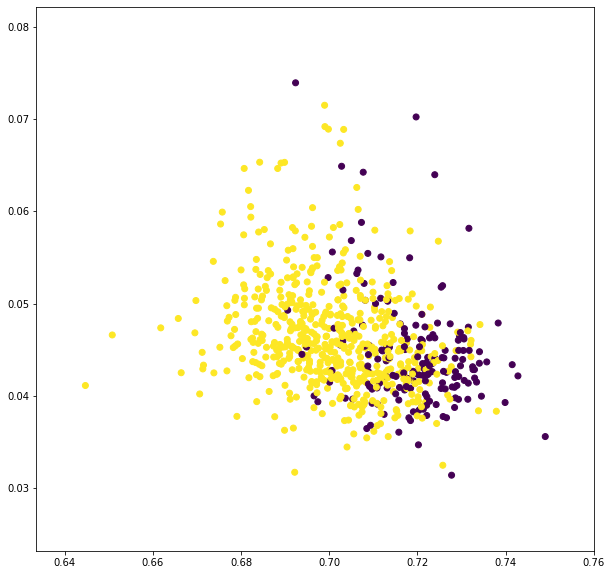

In [15]:
kernel = parenclitic.pdf_kernel(thr_type = 'best', min_score = 0.9, division_rule = 'non_control')
fit_mask = (mask == -1) | (mask == 1)
gene_1 = np.random.randint(14743)
gene_1 = 229
gene_2 = 255

kernel.fit(X[:, gene_1], X[:, gene_2], y, mask)
[G, D] = kernel.get_edges()
plt.figure(figsize=(10,10))
plt.scatter(X[fit_mask, gene_1], X[fit_mask, gene_2], c = y[fit_mask])
print(gene_1, gene_2)

In [82]:
y

array([ 1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1

In [118]:
G.sum()

496

In [63]:
np.flatnonzero(all_features_names == "ELOVL2")

array([9481], dtype=int64)

In [9]:
paths = []
for id_sample in config.params["id_sample"]:
    paths.append(config.ofname(["graphs", "g"], ext = ".tsv", include_set = config.params_sets["graph"]))
clf.set_graph_paths(paths = paths[:87])
clf.save_graphs(gtype = 'csv')

paths = []
for id_sample in config.params["id_sample"]:
    paths.append(config.ofname(["graphs", "g"], ext = ".npz", include_set = config.params_sets["graph"]))
clf.set_graph_paths(paths = paths[:87])
clf.save_graphs(gtype = 'npz')

In [7]:
config.ofname(["graphs", "g"], ext = ".tsv", include_set = config.params_sets["graph"])

'Z:\\PC\\UNN\\Science\\Gerontology\\data\\GSE52588\\params\\num_genes_14756\\kde_mask_siblings_mask\\algorithm_kde\\thr_p_0.88\\graphs\\graph_id_sample_0.tsv'

In [8]:
mask[:29].shape, mask.shape, 

((29,), (87,))

In [26]:
gr = clf.get_graphs()
print([g.ecount() for g in gr])

[2, 2, 4, 0, 1, 0, 1, 2, 30, 0, 1, 0, 8, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 0, 0]


In [14]:
    paths = []
    for id_sample in config.params["id_sample"]:
        paths.append(config.ofname(["graphs", "g"], ext = ".tsv", include_set = config.params_sets["graph"]))
    clf.set_graph_paths(paths = paths)
    clf.save_graphs(gtype = 'csv')
    
    paths = []
    for id_sample in config.params["id_sample"]:
        paths.append(config.ofname(["graphs", "g"], ext = ".npz", include_set = config.params_sets["graph"]))
    clf.set_graph_paths(paths = paths)
    clf.save_graphs(gtype = 'npz')

In [4]:
paths = []
for id_sample in config.params["id_sample"]:
    print(config.ofname(["graphs", "g"], ext = ".tsv", include_set = config.params_sets["graph"]))
    break

D:\PC\UNN\Science\Gerontology\data\GSE52588\params\num_genes_14756\kde_mask_mongoloids_mask\algorithm_kde\thr_p_0.1\graphs\graph_id_sample_0.tsv


In [ ]:
clf.save_graph()

In [33]:
from annotations.cpgs import cpgs_annotation
cpgs = cpgs_annotation(config.ifname('cpgs_annotations'))

In [66]:
bad_cpgs = np.loadtxt(config.ifname('bad_cpgs'), dtype='str')
crit = {'gene_out': [np.NaN], 'cpgs_in': all_features_names, 'cpgs_out': bad_cpgs, 'geotype_out': [np.NaN], 'chr_out': ['X', 'Y']}
genes = cpgs.get_crit_col_values('gene', crit)
print(len(genes))

['RBL2', 'ACTN1', 'ATP2A1', 'SFRP1', 'NIPA2', 'MAN1B1', 'TSEN34', 'LRRC16A', 'CNBP', 'DDX55']
15072


In [70]:
df = cpgs.get_sub_frame(crit)

In [71]:
print(df2)

In [73]:
gene_sum = defaultdict([0, 0])
for id_cpg, row in df.iterrows():
    print(id_cpg, row['UCSC_REFGENE_NAME'], row['ID_REF'])
    for x in list(row['UCSC_REFGENE_NAME']):
        gene_sum[x] += row['']

0 RBL2 cg00000029
5 ACTN1 cg00000289
6 ATP2A1 cg00000292
7 SFRP1 cg00000321
9 NIPA2 cg00000622
10 MAN1B1 cg00000658
11 TSEN34 cg00000714
12 LRRC16A cg00000721
13 CNBP cg00000734
14 DDX55 cg00000769
15 KLHL29 cg00000807
16 TLR2 cg00000884
18 {'KCNQ1', 'KCNQ1OT1'} cg00000924
20 NPHP4 cg00000957
21 PSKH2 cg00001099
22 MRPS25 cg00001245
26 MAEL cg00001349
28 ELOVL1 cg00001446
31 {'ZMIZ1', 'LOC283050'} cg00001582
32 NR5A2 cg00001583
34 ROCK2 cg00001594
35 CDK10 cg00001687
40 DNAJA2 cg00001854
41 ATOH7 cg00001874
43 PINK1 cg00002028
44 LRFN1 cg00002033
45 RWDD2B cg00002080
46 MRPL12 cg00002116
50 RTTN cg00002236
51 CD2BP2 cg00002406
52 SLMAP cg00002426
54 NOV cg00002464
56 MXD4 cg00002490
59 TAS1R3 cg00002593
60 ITGAD cg00002597
62 SMARCC2 cg00002660
63 C1orf114 cg00002719
66 C1orf65 cg00002808
68 DAB1 cg00002810
71 BDH1 cg00003014
72 SLBP cg00003091
73 {'TMEM43', 'CHCHD4'} cg00003173
76 RFX5 cg00003202
78 LHX5 cg00003298
81 CASZ1 cg00003513
86 {'CCDC45', 'DDX5'} cg00003784
88 RNF220 cg00003

KeyboardInterrupt: 

In [54]:
from tqdm import tqdm
cur_crit = crit
Xg = np.zeros((X.shape[0], len(genes)))
for i, gene in tqdm(enumerate(genes), ncols = 100):
    cur_crit['gene_in'] = gene
    cpgs_names, ids = cpgs.get_cpgs(cur_crit)
    cpgs_names, ids, ids2 = np.intersect1d(all_features_names, cpgs_names, return_indices = True)
    cur = np.mean(X[:, ids], axis = 1)
    Xg[:, i] = cur
    #print(cur.shape)
    #break

4it [00:15,  3.95s/it]

KeyboardInterrupt: 

In [ ]:
df.group

In [43]:
len(genes)
    

15072

In [ ]:

#cur = cpgs.get_sub_frame({'chr_in': ['22'], 'geotype_ex': ['Island']})
#df = cpgs.get_cpgs({'chr_in': ['22'], 'geotype_ex': ['Island']})
cpgs_names, _ = cpgs.get_cpgs({'gene_out': [np.NaN]})
cpgs_ids = np.array([y for x in cpgs_names for y in np.flatnonzero(all_features_names == x).tolist()])

In [16]:
len(all_features_names)

14756

In [21]:
genes_names = np.loadtxt('D:\\PC\\UNN\\Science\\Gerontology\\data\\GSE52588\\genes_names.txt', dtype = 'str')

In [22]:
len(genes_names)

15024

In [23]:
genes_names

array(['SOX9', 'L3MBTL', 'KHSRP', ..., 'TMED3', 'C6orf114', 'CDK5R2'],
      dtype='<U18')

In [42]:
new_names, ids1, ids2 = np.intersect1d(all_features_names, genes_names, return_indices = True, assume_unique = True)

In [43]:
all_features_names[ids1[0]], genes_names[ids2[0]]
ids1[0], ids2[0]

(13747, 6785)

In [55]:
from tqdm import tqdm
to_gene_ids = [np.nonzero(all_features_names == genes_names[i])[0].item(0) \
               for i in tqdm(range(len(genes_names)), ncols = 100)]

  0%|                                                                     | 0/15024 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [64]:
to_gene_ids = np.ones(len(genes_names), dtype = np.int32) * -1
for i in tqdm(range(len(genes_names)), ncols = 100):
    cur = np.nonzero(all_features_names == genes_names[i])[0]
    if len(cur) > 0:
        to_gene_ids[i] = cur.item(0)


100%|███████████████████████████████████████████████████████| 15024/15024 [00:01<00:00, 9124.70it/s]

In [60]:
to_gene_ids.shape

(15024,)

In [65]:
IDS2 = np.array(IDS)
for i in range(len(IDS)):
    u = to_gene_ids[IDS[i, 0]]
    v = to_gene_ids[IDS[i, 1]]
    IDS2[i, 0] = u
    IDS2[i, 1] = v

In [79]:
mask_ids = (IDS2[:, 0] == -1) | (IDS2[:, 1] == -1)

In [82]:
IDS3 = IDS2[~mask_ids, :]

In [85]:
IDS2.shape, mask.shape, IDS3.shape

((1468146, 2), (87,), (1355916, 2))

In [84]:
np.savez(config.ifname("good_pairs"), IDS = IDS3)

In [10]:
X.shape[1] * (X.shape[1] - 1) // 2 / len(IDS) * 853 / 3600

19.023551989536553

In [7]:
len(IDS)

1355916

In [17]:
import multiprocessing as mp
import multiprocessing, logging
mpl = multiprocessing.log_to_stderr()
mpl.setLevel(logging.DEBUG)
from tmp import *

if __name__ == "__main__":
    main(X, y, mask)

[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2824
[DEBUG/MainProcess] created semlock with handle 2752
[DEBUG/MainProcess] created semlock with handle 2752
[DEBUG/MainProcess] created semlock with handle 2752
[DEBUG/MainProcess] created semlock with handle 2752
[DEBUG/MainProcess] created semlock with handl

1


[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] terminating pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainProcess] finalizing pool
[DEBUG/MainPro

[DEBUG/MainProcess] joining worker handler
[DEBUG/MainProcess] ensuring that outqueue is not full
[DEBUG/MainProcess] joining worker handler
[DEBUG/MainProcess] ensuring that outqueue is not full
[DEBUG/MainProcess] joining worker handler
[DEBUG/MainProcess] ensuring that outqueue is not full
[DEBUG/MainProcess] terminating workers
[DEBUG/MainProcess] ensuring that outqueue is not full
[DEBUG/MainProcess] terminating workers
[DEBUG/MainProcess] result handler exiting: len(cache)=0, thread._state=2[DEBUG/MainProcess] terminating workers

[DEBUG/MainProcess] terminating workers
[DEBUG/MainProcess] result handler exiting: len(cache)=0, thread._state=2
[DEBUG/MainProcess] terminating workers
[DEBUG/MainProcess] result handler exiting: len(cache)=0, thread._state=2
[DEBUG/MainProcess] terminating workers
[DEBUG/MainProcess] result handler exiting: len(cache)=0, thread._state=2
[DEBUG/MainProcess] terminating workers
[DEBUG/MainProcess] result handler exiting: len(cache)=0, thread._state=2
[

[(array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]]), array([-0.10045865,  0.38741675,  0.17679457,  0.16707687, -0.01740339,
        0.09363793,  0.6370762 ,  0.31548882,  0.21391252,  0.03413122,
        0.06766567,  0.22052224,  0.43958214,  0.5861962 ,  0.03449933,
       -0.04434159,  0.4420338 ,  0.05798579, -0.11634251, -0.18283941,
        0.23762888

In [ ]:
#import Pool
from multiprocessing import Pool
#Define a worker — a function which will be executed in parallel
def worker(x):
    return x*x
#Assuming you want to use 3 processors
num_processors = 3
#Create a pool of processors
p=Pool(processes = num_processors)
#get them to work in parallel
output = p.map(worker,[i for i in range(0,3)])
print(output)

parenclitic.classes.classifier_kernel

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 503, 421, 403, 501, 756, 547, 646, 605, 541, 672, 654, 539, 484, 619, 398, 410, 460, 528, 576, 694, 638, 485, 571, 578, 734, 576, 612, 397, 646, 514, 526, 542, 730, 739, 751, 801, 672, 703, 813, 747, 700, 716, 494, 706, 560, 451, 552, 661, 712, 814, 786, 699, 646, 666, 673, 727, 566, 679]


In [9]:
from transform_data import * 

In [13]:
make_genes_edge(X[:, 0], X[:, 1], X[:, 0], X[:, 1], [0.8])

[6.44163452e-03 5.85362531e-02 1.55135318e-01 ... 5.82742013e+05
 5.82867412e+05 1.00000000e+00]


array([[ True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True, False, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False,  True, False, False, False,  True, False, False,
        False, False, False,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True]])

In [ ]:
data = np.random.normal(size = 1000)
kde = stats.gaussian_kde(data)

In [97]:
num_points = 1000000
points = kde.resample(num_points)
pr = np.array(kde(points))
pr.sort()
thr_p = 0.2
print(pr.shape)
p = 0.2
pos = np.searchsorted(pr, p)
w = float(num_points - pos) / num_points
print(w, abs(w - wl))

(1000000,)
0.747832 0.0013896868650297156


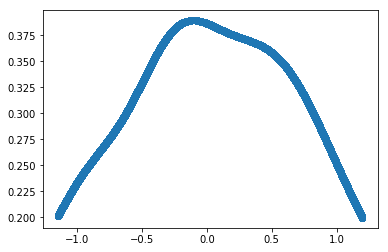

In [98]:
x = np.linspace(-1.15, 1.2, 10000000)
plt.plot(x, kde(x), 'o')
wl = ((x[1] - x[0]) * kde(x)).sum()

In [99]:
print(w, abs(w - wl))

0.747832 0.0013943507527764964


In [45]:
((x[1] - x[0]) * kde(x)).sum()

0.9999999420213942

In [7]:
while True:
    pass

KeyboardInterrupt: 